# Notebook 3: Estimating Proportions

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import pandas as pd

def make_pmf(sample):
    """Make a Series that represents a PMF.
    
    sample: sequence of quantities
    
    returns: Pandas Series
    """
    return pd.Series(sample).value_counts(normalize=True, sort=False).sort_index()

In [4]:
def plot_pmf(sample, **options):
    """Plot the PMF of a sample as a bar chart."""
    pmf = make_pmf(sample)
    plt.bar(pmf.index, pmf.values, **options)

In [5]:
def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    pmf = make_pmf(sample)
    cdf = pmf.cumsum()
    plt.plot(cdf.index, cdf.values, **options)

In [6]:
def decorate_heads(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of heads')
    plt.ylabel(ylabel)
    plt.title('Distribution of heads')
    plt.legend()

In [22]:
def sample_pmf(pmf, size):
    """Draw a sample from a PMF.
    
    pmf: Pandas Series
    size: number of elements
    
    returns: NumPy array
    """
    return np.random.choice(pmf.index, size, p=pmf.values)

## Binomial distribution



In [7]:
from scipy.stats import binom

n = 250
p = 0.5
sample_binomial = binom.rvs(n, p, size=1000)
np.mean(sample_binomial)

125.277

Here's what the distribution looks like.

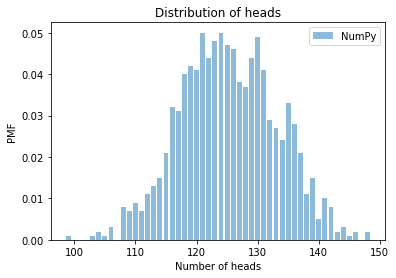

In [8]:
plot_pmf(sample_binomial, label='NumPy', alpha=0.5)
decorate_heads()

## Evaluating the Binomial distribution



In [9]:
ks = np.arange(90, 160)
ps = binom.pmf(ks, n, p)

Here's the analytic distribution we just computed compared to the PMF of the sample.

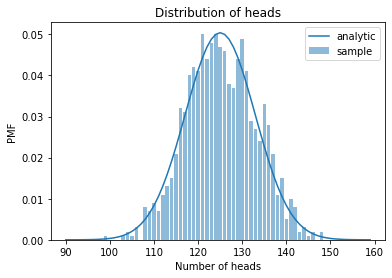

In [10]:
plot_pmf(sample_binomial, label='sample', alpha=0.5)
plt.plot(ks, ps, label='analytic')

decorate_heads()

## The Likelihood Function

We can also use the analytic PMF to compute the probability of a given outcome.


In [11]:
data = 140
binom.pmf(data, n, p)

0.008357181724918204

In [12]:
xs = np.linspace(0, 1, num=101)
likelihood = binom.pmf(data, n, xs)

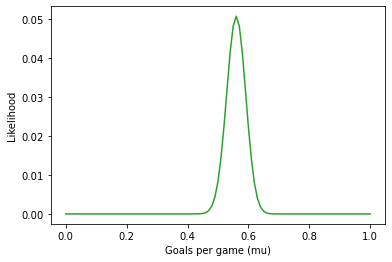

In [13]:
plt.plot(xs, likelihood, color='C2')
plt.xlabel('Goals per game (mu)')
plt.ylabel('Likelihood');

This graph shows the likelihood function we can use to do a Bayesian update.

## Bayesian inference with grid approximation



We can use `make_beta_pmf` to construct a prior PMF with given parameters.

In [14]:
from scipy.stats import beta as beta_dist

def make_beta_pmf(qs, alpha, beta):
    """Makes a PMF based on a gamma distribution.
    
    qs: places to evaluate the PDF
    alpha, beta: parameters of the distribution
    
    returns: pd.Series
    """
    ps = beta_dist(alpha, beta).pdf(qs)
    pmf = pd.Series(ps, index=qs)
    pmf /= pmf.sum()
    return pmf

Here's what it looks like with parameters I chose based on what I know about goal-scoring rates in hockey.

In [15]:
alpha = 2
beta = 2

xs = np.linspace(0, 1, num=101)
prior = make_beta_pmf(xs, alpha, beta)

Here's what it looks like.

In [16]:
def decorate_proportion(ylabel='PDF'):
    """Decorate the axes."""
    plt.xlabel('Proportion of heads (x)')
    plt.ylabel(ylabel)
    plt.title('Distribution of proportion')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

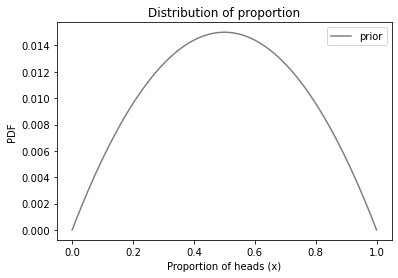

In [17]:
prior.plot(label='prior', color='gray')
decorate_proportion()

In [18]:
data = 140
likelihood = binom.pmf(data, n, xs)

In [19]:
posterior = prior * likelihood
posterior /= posterior.sum()

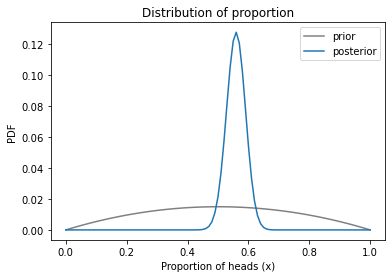

In [20]:
prior.plot(color='gray', label='prior')
posterior.plot(label='posterior')
decorate_proportion()

In [21]:
prior.idxmax(), posterior.idxmax()

(0.5, 0.56)

In [23]:
sample_prior_grid = sample_pmf(prior, 1000)
sample_prior_grid.mean()

0.49486

And a sample from the posterior distribution.

In [24]:
sample_post_grid = sample_pmf(posterior, 1000)
sample_post_grid.mean()

0.55836

## Back to PyMC

Previously we used PyMC to draw a sample from a Poisson distribution with known `mu`.

Now we'll use it to draw a sample from a gamma distribution of `mu`, with known `alpha` and `beta`.

And then use that value of `mu` to draw a sample from a Poisson distribution.

Here's what the PyMC model looks like:

In [25]:
n = 250
k_obs = 140

In [26]:
with pm.Model() as model:
    x = pm.Beta('x', alpha=2, beta=2)
    k = pm.Binomial('k', n=n, p=x)
    trace = pm.sample_prior_predictive(500)

The distribution of `mu` from this model is the prior.  Let's see what it looks like:

In [27]:
sample_prior_pymc = trace['x']
np.mean(sample_prior_pymc)

0.48400282770891234

And compare it to the sample we drew from the gamma prior.

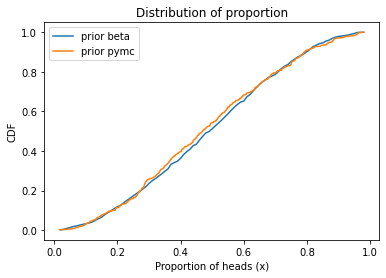

In [28]:
plot_cdf(sample_prior_grid, label='prior beta')
plot_cdf(sample_prior_pymc, label='prior pymc')
decorate_proportion('CDF')

Looks good.

## The prior predictive distribution

This model actually generates two variables:

1. Values of `mu` drawn from the prior distribution.

2. Values of `goals` drawn from the prior predictive distribution.

Remember that `mu` is a rate in goals per game, and `goals` is an integer number of goals.

We can get a sample of `goals` from the trace.

In [29]:
sample_prior_pred = trace['k']
sample_prior_pred.mean()

121.004

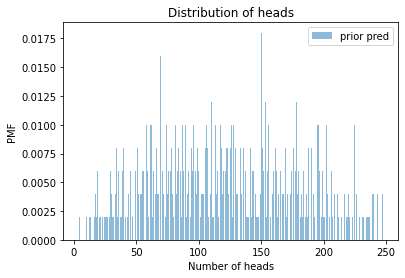

In [30]:
plot_pmf(sample_prior_pred, label='prior pred', alpha=0.5)
decorate_heads()

This distribution shows the distribution of goals we should expect in a game, based on the prior distribution only, not the data.

It is useful for model-checking, but it is also a step along the way to inference.

## When do we get to inference?

Finally, we are ready to use PyMC for actual inference.  We just have to make one small change.

Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data, `4`.

And instead of calling `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `mu`.

In [31]:
with pm.Model() as model:
    x = pm.Beta('x', alpha=2, beta=2)
    k = pm.Binomial('k', n=n, p=x, observed=k_obs)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  

In [32]:
len(trace['x'])

2000

We can plot the posterior using a function provided by PyMC:

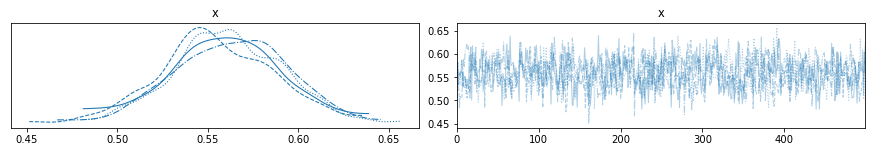

In [33]:
import arviz as az

with model:
    az.plot_trace(trace)

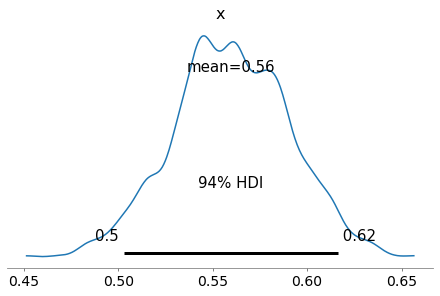

In [34]:
import arviz as az

with model:
    az.plot_posterior(trace)

We can extract a sample of `mu` from the trace.

In [35]:
sample_post_pymc = trace['x']
np.mean(sample_post_pymc)

0.5596825043816901

And compare it to a sample from the grid approximation:

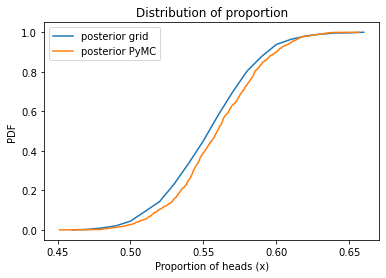

In [36]:
plot_cdf(sample_post_grid, label='posterior grid')
plot_cdf(sample_post_pymc, label='posterior PyMC')
decorate_proportion()

## Hierarchical Model

In [37]:
with pm.Model() as model:
    
    alpha = pm.Gamma('alpha', alpha=3, beta=1)
    beta = pm.Gamma('beta', alpha=3, beta=1)
        
    x = pm.Beta('x', alpha, beta)
    
    ks = pm.Binomial('ks', n=250, p=x)
    trace = pm.sample_prior_predictive(1000)

with model:
    az.plot_posterior(trace, var_names=['alpha', 'beta', 'x'])

data = [140, 130, 120]

with pm.Model() as model:
    
    alpha = pm.Gamma('alpha', alpha=3, beta=1)
    beta = pm.Gamma('beta', alpha=3, beta=1)
        
    xs = pm.Beta('xs', alpha, beta, shape=len(data))
    
    ks = pm.Binomial('ks', n=250, p=xs, observed=data)
    trace = pm.sample(1000)

with model:
    az.plot_trace(trace)

with model:
    az.plot_posterior(trace)

alphas = trace['alpha']
betas = trace['beta']
sample_posterior_x = beta_dist.rvs(alphas, betas)
sample_posterior_x.mean()

with model:
    az.plot_posterior(sample_posterior_x)